In [15]:
import os, glob, sys
import numpy as np
from sklearn.svm import LinearSVC, SVC
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error
from sklearn.utils import shuffle
from sklearn.decomposition import KernelPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_predict

In [16]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true) + 1, np.array(y_pred) + 1
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def rmse(targets, predictions):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [17]:
def knn_classification(X_train, X_test, y_train, y_test ):
#    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    print("accuracy:", accuracy_score(y_test, y_pred))
    print("precision: ", precision_score(y_test, y_pred, pos_label=1, average='micro'))
    print("recall: ", recall_score(y_test, y_pred, pos_label=1, average='micro'))
    print("root-mean-square error:", rmse(y_test, y_pred))
    print("mean_absolute_percentage_error:", mean_absolute_percentage_error(y_test, y_pred))
    return pd.DataFrame(confusion_matrix(y_test, y_pred))

In [18]:
def svm(X_train, X_test, y_train, y_test):
    svclassifier = SVC(kernel='rbf')
    svclassifier.fit(X_train, y_train)
    y_pred = svclassifier.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    print("accuracy:", accuracy_score(y_test, y_pred))
    print("precision: ", precision_score(y_test, y_pred, pos_label=1, average='micro'))
    print("recall: ", recall_score(y_test, y_pred, pos_label=1, average='micro'))
    print("root-mean-square error:", rmse(y_test, y_pred))
    print("mean_absolute_percentage_error:", mean_absolute_percentage_error(y_test, y_pred))
    return pd.DataFrame(confusion_matrix(y_test, y_pred))

In [19]:
def LSVC_(data, label, n_features):
    """returns the features selected based on linearSVC,
    data. label should be numpy array"""
    lsvc = LinearSVC(C=1, penalty="l1", dual=False).fit(data, label)
    coef = np.squeeze(np.sum(np.square(np.array(lsvc.coef_)), axis=0))
    coefidx = np.argsort(coef)
    fidx = coefidx[-n_features:]
    return fidx

In [20]:
path = '/Users/fatemeh/Net_project/02-PreprocessedDatasets/data/' + '*.csv'   
files = glob.glob(path)
data = []
for file in files:
    data.append(pd.read_csv(file))
data = pd.concat(data)

In [21]:
columns_name = data.columns[0].split("\t")
data.columns = ['Col']
    
data = data.Col.apply(lambda x: pd.Series(str(x).split("\t")))
data = data.set_index(data.columns[0])
data.columns = columns_name[1:]
data = data.astype('int32')
#take the labels and remove it from dataset
label = data['wbcqi'].to_numpy()
data = data.drop(['wbcqi'], axis=1)
data = data.drop(['macStats_mcs1Dl'], axis=1)

In [22]:
data, label = shuffle(data, label, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.25, random_state=1)
#selected_indx = list(LSVC_(X_train, y_train, 15))
#features selected exhaustive search
selected_indx = [2, 15, 0, 7, 19] #,19, 29, 34, 31, 36, 30,24, 13, 38]
selected_cols = data.columns[selected_indx]
data_selected_5 = data[selected_cols]

In [23]:
confusion_mat = []
kf = KFold(n_splits=3, shuffle=False)
for train_index, test_index in kf.split(data_selected_5):
    X_train, X_test = data_selected_5.iloc[train_index], data_selected_5.iloc[test_index]
    y_train, y_test = label[train_index], label[test_index]
    confusion_mat.append(knn_classification(X_train, X_test, y_train, y_test))  

[[   0    0    0    0    0    0    0    1    2    0    0    0    2    0
     2]
 [   0    0    0    1    0    0    0    0    0    0    0    0    0    0
     0]
 [   1    0  134    6    1    0    0    0    0    0    0    0    0    0
     1]
 [   0    0    4   46   10    0    1    1    0    0    0    0    0    0
     0]
 [   0    0    0   15  135   39    7    1    1    0    0    0    0    0
     0]
 [   0    0    1    3   33  280   55    8    1    0    0    0    0    0
     0]
 [   0    0    0    0    9   67  545   95   18    0    0    0    0    0
     0]
 [   8    0    0    0    1    9   97  843  145   17    5    1    0    0
     0]
 [   0    0    0    0    0    5   24  150  400   81    9    3    2    0
     0]
 [   0    0    0    0    1    1    5   17   74  162   33    6    1    1
     0]
 [   0    0    0    0    0    0    0    1    6   31   91   28   12    2
     2]
 [   0    0    0    0    0    0    0    0    3   12   28  187   54    9
    14]
 [   0    0    0    0    0    0    0    

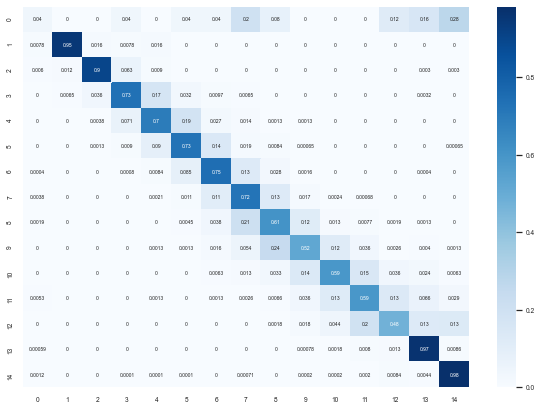

In [24]:
confusion_sum = confusion_mat[0].add(confusion_mat[1], fill_value=0).add(confusion_mat[2], fill_value=0)
confusion_sum = (confusion_sum/3)
sum_ = confusion_sum.sum(axis=1)
normalize = confusion_sum.div(sum_.values, axis='index')
sns.set(font_scale=0.6)
plt.figure(figsize = (10, 7))
sns.heatmap(normalize, annot=True, cmap='Blues', annot_kws={"size": 5})
plt.savefig('confusion_mat_5selected_knn.pdf')
plt.show()

In [25]:
def T_SNE(mat):
    print("running TSNE...")
    TSNE_result = TSNE(learning_rate = 50).fit_transform(mat)
    df = pd.DataFrame()
    df['x'] = TSNE_result[:,0]
    df['y'] = TSNE_result[:,1]
    return df

In [26]:
data_tsne = T_SNE(data)
confusion_mat = []
kf = KFold(n_splits=3, shuffle=False)
for train_index, test_index in kf.split(data_tsne):
    X_train, X_test = data_tsne.iloc[train_index], data_tsne.iloc[test_index]
    y_train, y_test = label[train_index], label[test_index]
    confusion_mat.append(knn_classification(X_train, X_test, y_train, y_test)) 

running TSNE...
[[   0    0    0    0    0    0    0    2    1    0    0    1    1    0
     2]
 [   0    0    0    1    0    0    0    0    0    0    0    0    0    0
     0]
 [   0    0  133    9    0    0    0    0    0    0    0    0    0    0
     1]
 [   0    0    2   46   10    3    1    0    0    0    0    0    0    0
     0]
 [   0    0    0    8  146   30   11    2    0    0    0    1    0    0
     0]
 [   0    0    1    1   29  300   40    8    2    0    0    0    0    0
     0]
 [   0    0    0    1    5   57  575   84   11    0    0    0    1    0
     0]
 [   6    0    0    0    3    7   82  902  111   14    0    1    0    0
     0]
 [   0    0    0    0    0    5   18  128  452   67    2    1    0    0
     1]
 [   0    0    0    0    0    0    0   16   67  172   38    7    1    0
     0]
 [   0    0    0    0    0    0    0    1    7   22  103   34    4    0
     2]
 [   1    0    0    0    0    0    0    0    2    8   34  197   58    1
     6]
 [   0    0    0    0   

In [27]:
data_tsne

,x,y
0,35.631519,-38.608383
1,13.425848,18.416435
2,12.936952,-13.193427
3,36.765404,28.878950
4,10.280433,45.839790
...,...,...
27721,-12.532746,26.993689
27722,-14.109701,0.359033
27723,-6.131819,-36.811607
27724,-27.295380,-21.637106


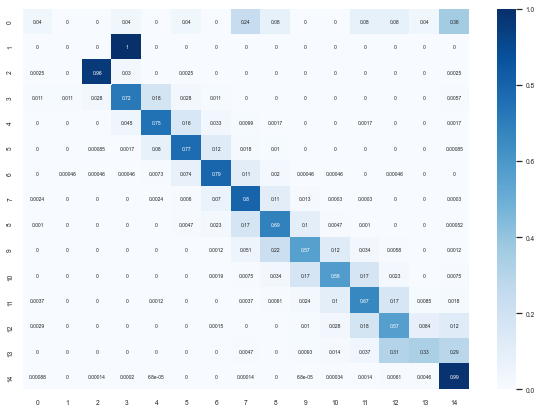

In [28]:
confusion_sum = confusion_mat[0].add(confusion_mat[1], fill_value=0).add(confusion_mat[2], fill_value=0)
confusion_sum = (confusion_sum/3)
sum_ = confusion_sum.sum(axis=1)
normalize = confusion_sum.div(sum_.values, axis='index')
sns.set(font_scale=0.6)
plt.figure(figsize = (10, 7))
sns.heatmap(normalize, annot=True, cmap='Blues', annot_kws={"size": 5})
plt.savefig('confusion_mat_knn_tsne.pdf')
plt.show()